# Valeo case study

**Disclaimer:**

This colabs is my first attempt to implement machine learning tools on a real dataset.

I may not use the state of the art methodology and I'm fine with it as my main purpose is to try, learn an uderstand. Feel free to point out any mistake or inconsistency in my try

# Library & utilities

In [2]:
# pandas stuff
import pandas as pd

#seaborn stuff
import seaborn as sns

import matplotlib.pyplot as plt

# sklearn stuff
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [33]:
features_to_drop=set()

#Datasets import

In [3]:
# for convenience purpose the data file is stored in my personal onedrive
url='https://github.com/dim2s/SAFI/raw/refs/heads/main/Dataset_pour_workshop.csv'

#this dataframe will contain raw data from valeo
valeo_data=pd.read_csv(url)

#this dataframe will contain all modifications
sandbox_data=valeo_data.copy()

#Data exploration & feature engineering

In [26]:
sandbox_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42516 entries, 0 to 42515
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   PROC_TRACEINFO                   42516 non-null  object        
 1   OP070_V_1_angle_value            42516 non-null  float64       
 2   OP090_SnapRingPeakForce_value    42516 non-null  float64       
 3   OP070_V_2_angle_value            42516 non-null  float64       
 4   OP120_Rodage_I_mesure_value      42516 non-null  float64       
 5   OP090_SnapRingFinalStroke_value  42516 non-null  float64       
 6   OP110_Vissage_M8_torque_value    42516 non-null  float64       
 7   OP100_Capuchon_insertion_mesure  19529 non-null  float64       
 8   OP120_Rodage_U_mesure_value      42516 non-null  float64       
 9   OP070_V_1_torque_value           42516 non-null  float64       
 10  OP090_StartLinePeakForce_value   42516 non-null  float64  

## PROC_TRACEINFO feature

In [4]:
len(sandbox_data["PROC_TRACEINFO"].unique())

42516

All entries from "PROC_TRACEINFO" are unique!

In [5]:
print(sandbox_data["PROC_TRACEINFO"].iloc[0])

I-B-XA1207672-190429-00688


Entries from PROC_TRACEINFO are composed from 3 parts:

* I-B-XA1207672 ref of the product
* 190429 date of the operation format (YYMMDD)
* ID of the product increment every 12s

In [7]:
re_patern=r'^([a-zA-Z]{1}-[a-zA-Z]{1}-[a-zA-Z]{2}\d{7})-(\d{2}\d{2}\d{2})-(\d+)$'

sandbox_data[["_reference","_date","_serial"]]=sandbox_data["PROC_TRACEINFO"].str.extract(re_patern)
sandbox_data.head(3)

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar_OP130_Resultat_Global_v,_reference,_date,_serial
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60,1,I-B-XA1207672,190429,00688
1,I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,1,I-B-XA1207672,190828,00973
2,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61,1,I-B-XA1207672,190712,03462


In [8]:
sandbox_data["_reference"].value_counts()

,count
_reference,
I-B-XA1207672,42516


All entries have the same product "I-B-XA1207672" reference.

we won't extract any additional information from this => this feature (*_reference*) can be drop on all rows

In [9]:
sandbox_data['_date']=pd.to_datetime(sandbox_data['_date'], format='%y%m%d')

In [10]:
sandbox_data['_day']=sandbox_data['_date'].dt.day_of_week
sandbox_data['_month']=sandbox_data['_date'].dt.month
sandbox_data.head()

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar_OP130_Resultat_Global_v,_reference,_date,_serial,_day,_month
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60,1,I-B-XA1207672,2019-04-29,00688,0,4
1,I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,1,I-B-XA1207672,2019-08-28,00973,2,8
2,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61,1,I-B-XA1207672,2019-07-12,03462,4,7
3,I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61,1,I-B-XA1207672,2019-08-03,00051,5,8
4,I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,NaN,11.97,6.62,29.22,33.6,99.19,6.61,1,I-B-XA1207672,2019-05-08,03248,2,5


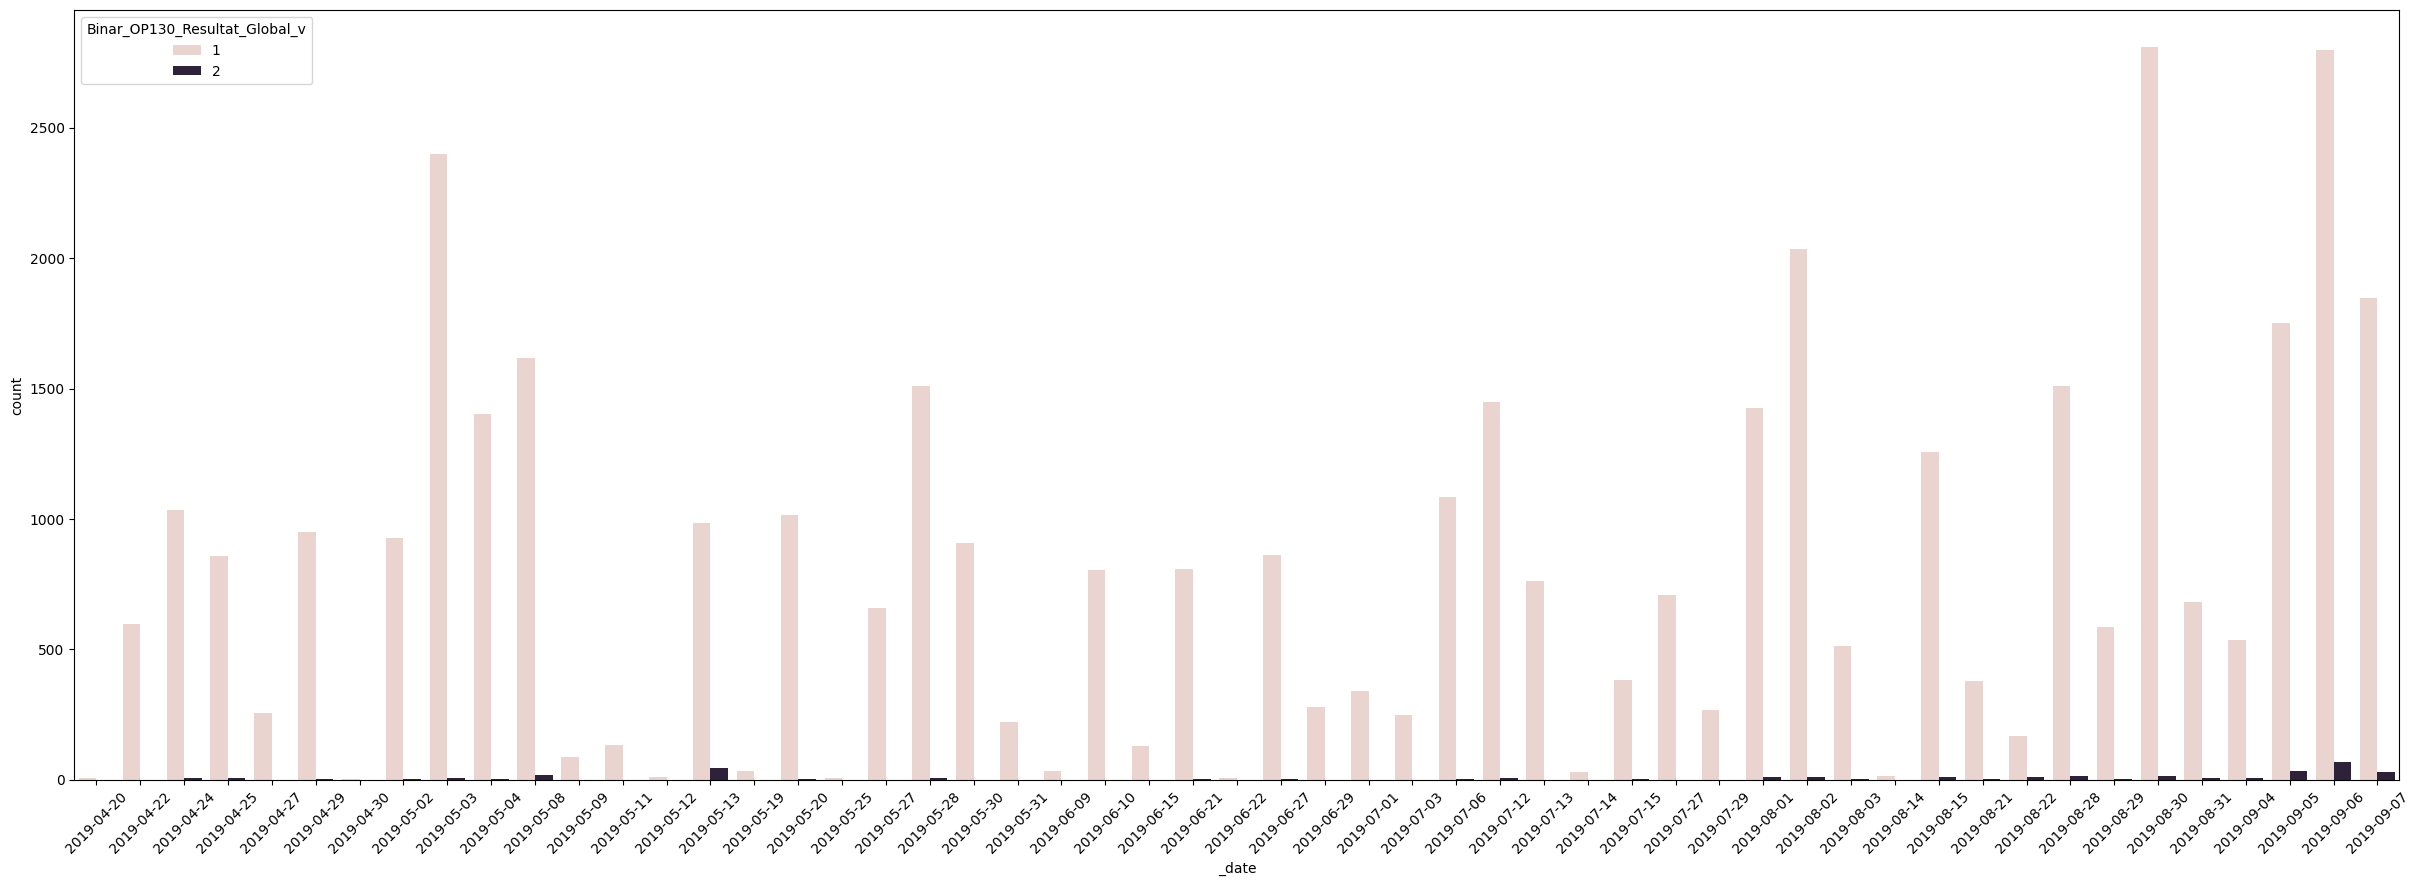

In [11]:
df=sandbox_data[['_date','Binar_OP130_Resultat_Global_v']].sort_values(by='_date')

plt.figure(figsize=(30,10))
sns.countplot(data=df, x='_date', hue='Binar_OP130_Resultat_Global_v')
plt.xticks(rotation=45)

plt.show()

### Is there a special frequency between incident?

In [22]:
ko_events=sandbox_data[sandbox_data['Binar_OP130_Resultat_Global_v']==2][['_date','Binar_OP130_Resultat_Global_v']].sort_values(by='_date')
ko_events_summary=ko_events.groupby('_date').count()

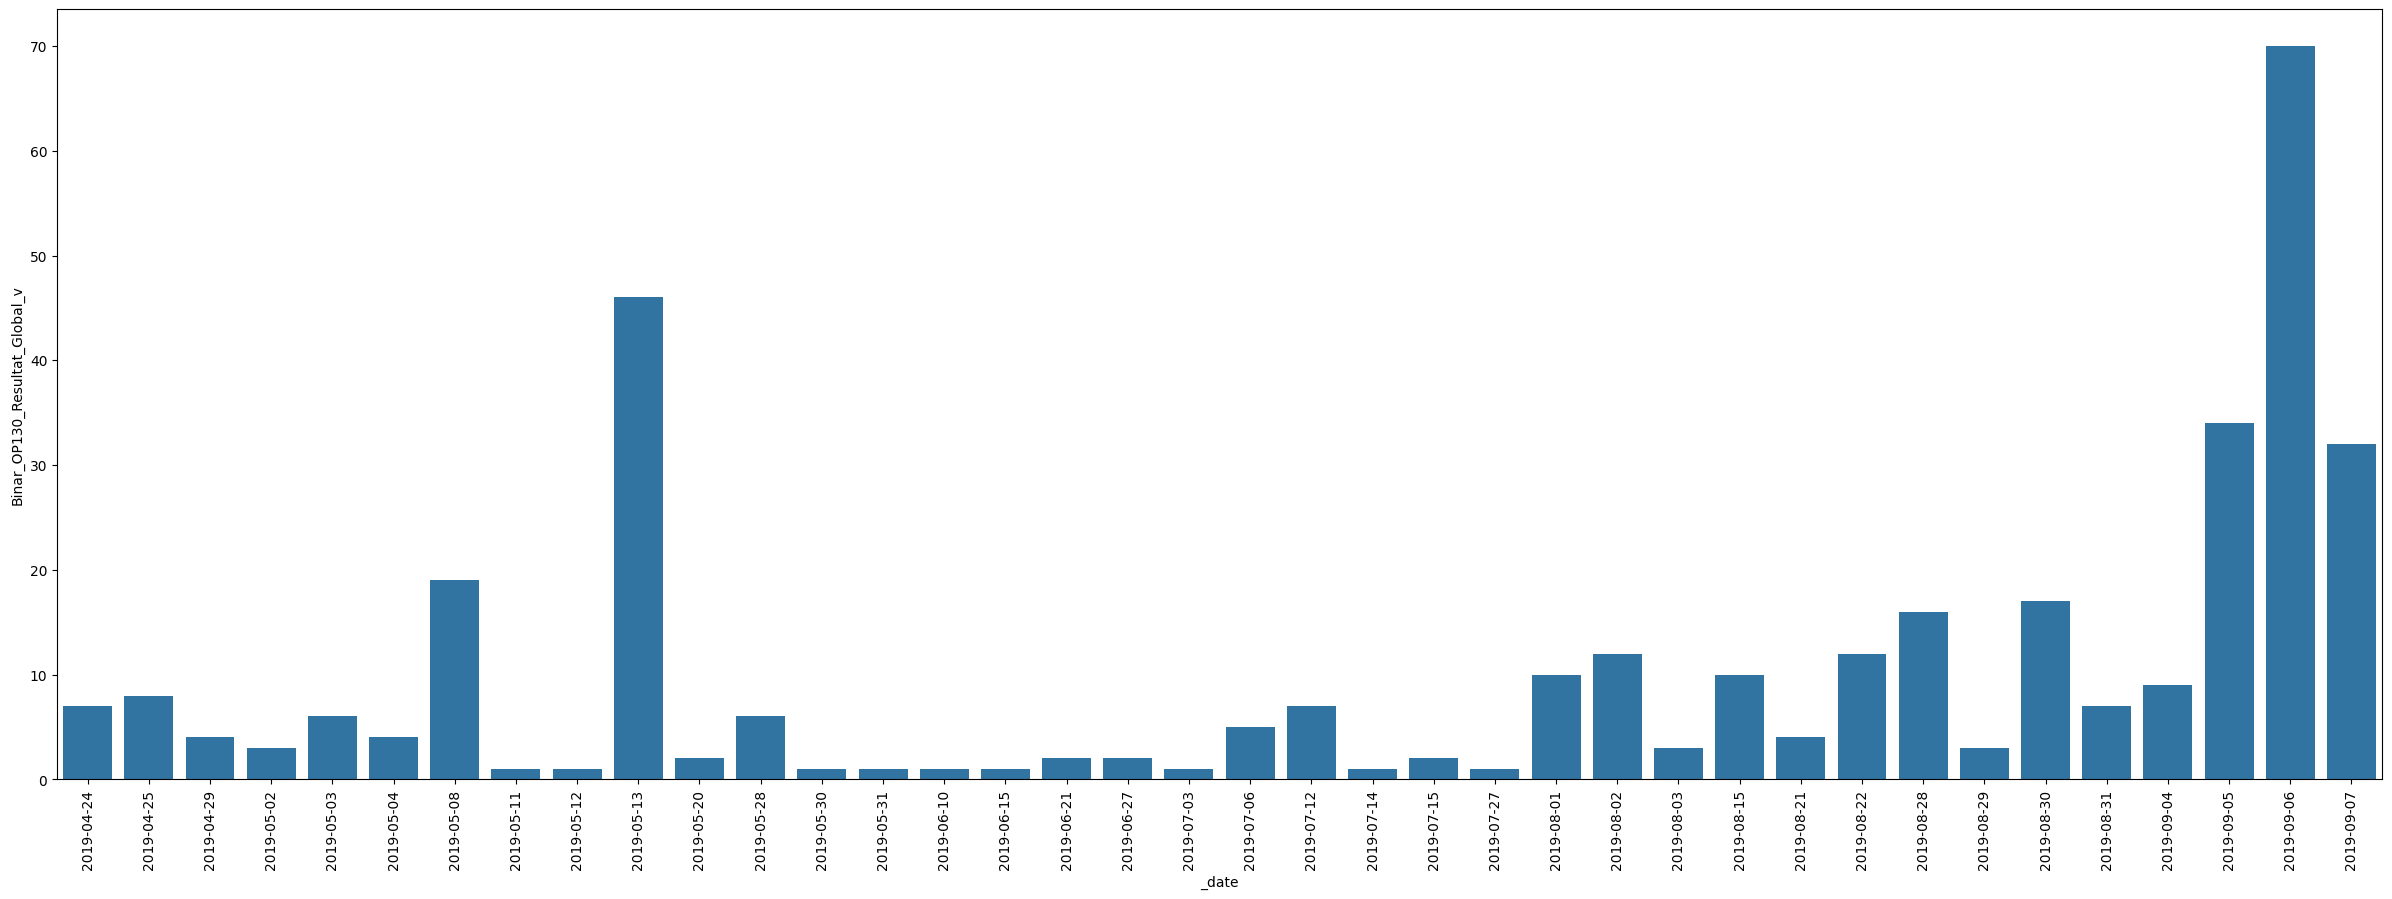

In [23]:
plt.figure(figsize=(30,10))
sns.barplot(data=ko_events_summary, x='_date', y='Binar_OP130_Resultat_Global_v')
plt.xticks(rotation=90)

plt.show()

In [21]:
ko_events

,_date,Binar_OP130_Resultat_Global_v
28579,2019-04-24,2
5153,2019-04-24,2
9106,2019-04-24,2
15683,2019-04-24,2
769,2019-04-24,2
...,...,...
24419,2019-09-07,2
18782,2019-09-07,2
24937,2019-09-07,2
8369,2019-09-07,2


In [25]:
ko_events_summary.sort_values(by='Binar_OP130_Resultat_Global_v', ascending=False).head(7)

,Binar_OP130_Resultat_Global_v
_date,
2019-09-06,70
2019-05-13,46
2019-09-05,34
2019-09-07,32
2019-05-08,19
2019-08-30,17
2019-08-28,16


the number of daily defects is not uniform.

We see a surge in daily defects at two specifics moments:


1.   Between the 2019-09-05 and 2019-09-07
2.   the 2019-05-13

the *'date'* may have some usable informations.
if the sample we use to train the model do not contain these specific dates it will miss almost 50% of the defects


In [28]:
sandbox_data['_reference'].value_counts()

,count
_reference,
I-B-XA1207672,42516


all references are the same: *I-B-XA-1207672* we can drop it

In [39]:
features_to_drop.add('_reference')

the *'_serial'* number is incremented every x seconds so obviously some will have more defect thant others but has the incrementation is perpetual I don't believe we could base our prediction on it => I propose to drop it also

In [40]:
features_to_drop.add('_serial')
features_to_drop

{'_reference', '_serial'}

##OP070 station

* OP070_V_1_angle_value            42516 non-null  float64       
* OP070_V_1_torque_value           42516 non-null  float64     
* OP070_V_2_angle_value            42516 non-null  float64  
* OP070_V_2_torque_value
      

##OP090 station

      
* OP090_SnapRingFinalStroke_value  42516 non-null  float64     
* OP090_SnapRingPeakForce_value    42516 non-null  float64
* OP090_StartLinePeakForce_value   42516 non-null  float64  
* OP090_SnapRingMidPointForce_val  42516 non-null  float64

      
      
      

##OP110 station


* OP110_Vissage_M8_torque_value    42516 non-null  float64       
* OP110_Vissage_M8_angle_value     42516 non-null  float64     


##OP120 station

* OP120_Rodage_U_mesure_value      42516 non-null  float64       
* OP120_Rodage_I_mesure_value      42516 non-null  float64

## OP100 station

OP100 capuchon mesure

##OP130 station

# Machine learning modelisation

## Naive gaussian bayes

In [49]:
#ToDo: a intégrer la suppression des columns dans le pipeline
target='Binar_OP130_Resultat_Global_v'
features_to_drop=['PROC_TRACEINFO','OP100_Capuchon_insertion_mesure', '_reference','_date', target ]

X=sandbox_data
y=sandbox_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', features_to_drop),
        #('fill_missing_value', SimpleImputer(strategy='mean'), ['OP100_Capuchon_insertion_mesure']),
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [51]:
pipeline = Pipeline([
    ('data_preparation', preprocessor),
    ('scaler', StandardScaler()),
    ("model", GaussianNB()  )
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preparation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['PROC_TRACEINFO',
                                                   'OP100_Capuchon_insertion_mesure',
                                                   '_reference', '_date',
                                                   'Binar_OP130_Resultat_Global_v'])])),
                ('scaler', StandardScaler()), ('model', GaussianNB())])

In [52]:
y_pred=pipeline.predict(X_test)

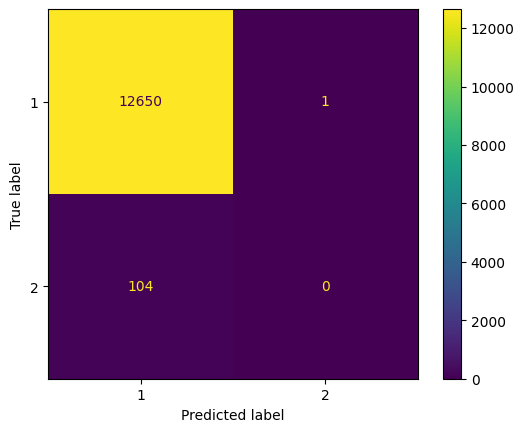

In [53]:
# no use for f1 score for the moment
# print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2])
cm_display.plot()